##  Classification what kind of activity a person is engaged in: walking, standing, running or climbing stairs using the accelerometer data from the mobile phone.

#### All necessary imports

In [2]:
import pandas as pd
import numpy as np
import os
import re
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
# imports to work with sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

#### loading and saving data

In [7]:
# Creating an empty DataFrame for store the data
all_data = pd.DataFrame()

main_folder = "/Users/olgatsyban/Downloads/data"

# Cycle for each dir in data folder
for current_folder in os.listdir(main_folder):
    # write path for current folder
    folder = os.path.join(main_folder, current_folder)
    # check is this folder a dir
    if os.path.isdir(folder):
        # Itarete aech file in dir
        for file_name in os.listdir(folder):
            # if file has extension .csv
            if file_name.endswith('.csv'):
                # write path for current folder
                file_path = os.path.join(folder, file_name)
                # read a data from file
                file_data = pd.read_csv(file_path)
                # add column 'activity'
                file_data['activity'] = current_folder
                # find file number 
                num=re.match(f'{current_folder}-(\d+).csv', file_name)
                # add column 'num'
                file_data['num']=int(num.group(1))
                # result data
                all_data = pd.concat([all_data, file_data], ignore_index=True)

                
# print first 5 lines              
all_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity,num
0,1.757344,-5.875371,-3.878607,running,3088
1,2.461239,12.986150,1.762132,running,3088
2,22.682667,22.922087,-1.738190,running,3088
3,11.875240,4.611233,-8.389283,running,3088
4,-5.295974,4.783615,-1.273715,running,3088


In [20]:
# Count amount of each activity
class_counts = all_data['activity'].value_counts()
print(class_counts)

activity
running    102240
walking     55500
idle        31170
stairs       4950
Name: count, dtype: int64


In [25]:
# Statistical characteristics of numerical data in data
all_data.describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z,num
count,193860.000000,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896,1249.626431
std,8.404867,12.474041,7.191590,930.683760
min,-39.188293,-39.188293,-39.188293,1.000000
25%,-2.494758,-8.327033,-2.494758,484.000000
50%,0.248997,-0.009577,0.905008,1022.500000
75%,4.668694,8.671799,7.187394,1822.000000
max,39.188293,39.188293,39.188293,3408.000000


In [26]:
# Get the size of the DataFrame using the shape attribute
size = all_data.shape
print(size)

(193860, 5)


In [18]:
# Find all dirs in data folder
activities = os.listdir(main_folder)
activities.remove('.DS_Store')
print(activities)

['running', 'idle', 'walking', 'stairs']


In [20]:
# Find amount of each file(activity)
for name in activities:
    path = os.path.join(main_folder, name)
    frames= os.listdir(path)
    print(f'{name} = {len(frames)}')

running = 3408
idle = 1039
walking = 1850
stairs = 165


In [21]:
# Get the data types of all columns using the dtypes attribute
col_types = all_data.dtypes
print(col_types)

accelerometer_X    float64
accelerometer_Y    float64
accelerometer_Z    float64
activity            object
num                  int64
dtype: object


In [31]:
# Count the proportion of missing values in each column
missing_values = all_data.isnull().sum()
print("Missing values:\n", missing_values)

missing_values_proportion = missing_values / all_data.shape[0]
print("\n",missing_values_proportion)

Missing values:
 accelerometer_X    0
accelerometer_Y    0
accelerometer_Z    0
activity           0
num                0
dtype: int64

 accelerometer_X    0.0
accelerometer_Y    0.0
accelerometer_Z    0.0
activity           0.0
num                0.0
dtype: float64


In [29]:
# General information about data
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   activity         193860 non-null  object 
 4   num              193860 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 7.4+ MB


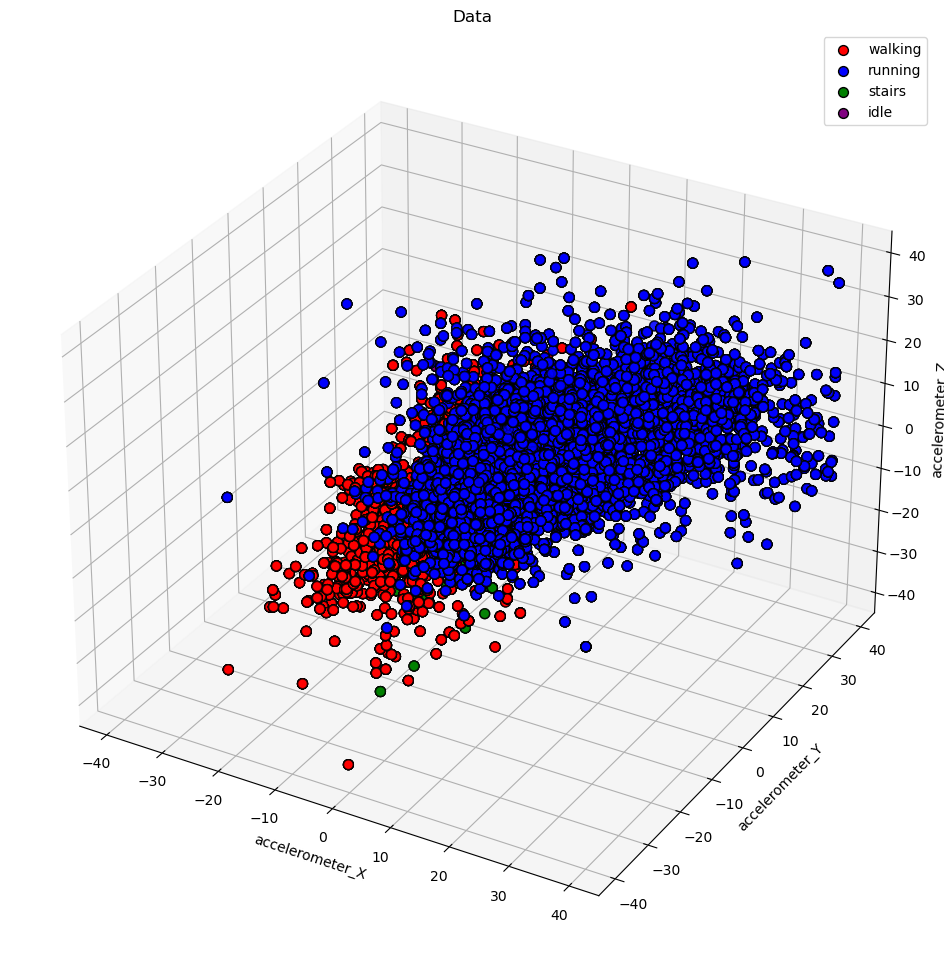

In [33]:
# Build a 3d diagram for accelerometer_X , accelerometer_Y ,accelerometer_Z features by activity

fig = plt.figure(figsize=(15, 12))

# syntax for 3-D projection
ax = plt.axes(projection='3d')

# defining all 3 axis
x = all_data['accelerometer_X']
y = all_data['accelerometer_Y']
z = all_data['accelerometer_Z']

# define colors for diagram
colors = {'walking': 'red', 'running': 'blue', 'stairs': 'green', 'idle': 'purple'}

for activity, color in colors.items():
    activity_data = all_data[all_data['activity'] == activity]
    ax.scatter3D(activity_data['accelerometer_X'], 
                 activity_data['accelerometer_Y'], 
                 activity_data['accelerometer_Z'], 
                 color=color, label=activity, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.set_title('Data')

plt.legend()
plt.show() 


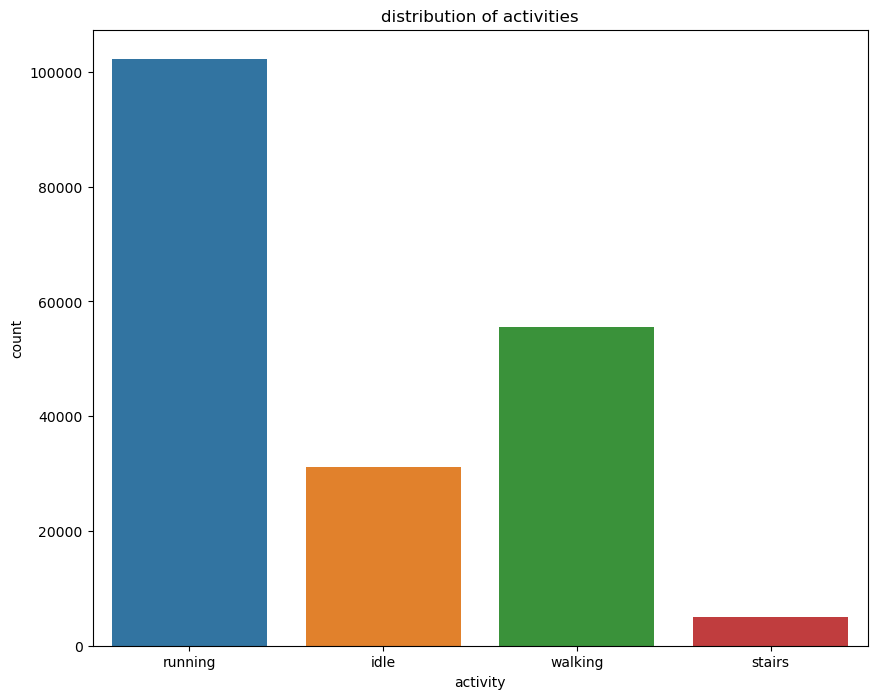

In [37]:
# diagram distribution of data
plt.figure(figsize=(10, 8))
sns.countplot(x='activity', data=all_data)
plt.title('distribution of activities')
plt.show()

### Creating and training model without time domain features

#### SVC

In [30]:
# Creating dict of weights
# Compare all activities to running (running has the most examples)
weight_dict = {'idle': 3408 / 1039, 'walking': 3408 / 1850, 'stairs': 3408 / 165, 'running': 1}

# Preparation data for model
X = all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y = all_data['activity']

# Creating training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Create model SVC (using the weights)
svm_model = SVC(class_weight=weight_dict)

# Train the model on data
svm_model.fit(X_train, y_train)

SVC(class_weight={'idle': 3.2800769971126083, 'running': 1,
                  'stairs': 20.654545454545456, 'walking': 1.8421621621621622})

In [38]:
# Find acuracy of predicted values using SVC
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy SVM: {accuracy}')
print('Classification Report:\n', report)

Accuracy SVM: 0.7936397400185701
Classification Report:
               precision    recall  f1-score   support

        idle       0.93      0.99      0.96      6178
     running       0.98      0.79      0.87     20510
      stairs       0.10      0.70      0.17       915
     walking       0.88      0.70      0.78     11169

    accuracy                           0.79     38772
   macro avg       0.72      0.80      0.69     38772
weighted avg       0.92      0.79      0.84     38772



#### RandomForest

In [40]:
# Create model RandomForest (using the weights)
rf_model = RandomForestClassifier(class_weight=weight_dict)

# Train the model on data X_train and y_train
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={'idle': 3.2800769971126083, 'running': 1,
                                     'stairs': 20.654545454545456,
                                     'walking': 1.8421621621621622})

In [41]:
# Find acuracy of predicted values using RandomForest
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f'Accuracy RF: {accuracy_rf}')
print('Classification Report:\n', report_rf)

Accuracy RF: 0.9998968327659136
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6178
     running       1.00      1.00      1.00     20510
      stairs       1.00      1.00      1.00       915
     walking       1.00      1.00      1.00     11169

    accuracy                           1.00     38772
   macro avg       1.00      1.00      1.00     38772
weighted avg       1.00      1.00      1.00     38772



### Creating and training model with time domain features

In [10]:
# ir = interquartile_range
# std = standard_deviation
# rmse = root_mean_square_error
def calculate_time_domain_features(data, column):
    time_domain_features = {}
    
    time_domain_features[f'{column}_mean'] = data[f'accelerometer_{column}'].mean()
    time_domain_features[f'{column}_max'] = data[f'accelerometer_{column}'].max()
    time_domain_features[f'{column}_min'] = data[f'accelerometer_{column}'].min()
    time_domain_features[f'{column}_median'] = data[f'accelerometer_{column}'].median()
    time_domain_features[f'{column}_std'] = data[f'accelerometer_{column}'].std()
    time_domain_features[f'{column}_rmse'] = np.sqrt(np.mean(data[f'accelerometer_{column}'] ** 2))
    time_domain_features[f'{column}_ir'] = np.percentile(data[f'accelerometer_{column}'], 75) - np.percentile(data[f'accelerometer_{column}'], 25)
    time_domain_features[f'{column}_range'] = np.max(data[f'accelerometer_{column}']) - np.min(data[f'accelerometer_{column}'])
        
    return time_domain_features

In [11]:
# find time features for each column in all_data frame 
features_X = calculate_time_domain_features(all_data, 'X')
features_Y = calculate_time_domain_features(all_data, 'Y')
features_Z = calculate_time_domain_features(all_data, 'Z')

In [12]:
# Copy DataFrame
copied_data = all_data.copy()

# Add time features to DataFrame 
copied_data = copied_data.assign(**features_X, **features_Y, **features_Z)

# Print result
#print(copied_data.head())
print(copied_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'X_mean', 'Y_mean', 'Z_mean']])    

        accelerometer_X  accelerometer_Y  accelerometer_Z   X_mean    Y_mean  \
0              1.757344        -5.875371        -3.878607  1.92355  1.598343   
1              2.461239        12.986150         1.762132  1.92355  1.598343   
2             22.682667        22.922087        -1.738190  1.92355  1.598343   
3             11.875240         4.611233        -8.389283  1.92355  1.598343   
4             -5.295974         4.783615        -1.273715  1.92355  1.598343   
...                 ...              ...              ...      ...       ...   
193855        -4.137180        -4.429273        -1.517924  1.92355  1.598343   
193856         1.829170        -9.313444        -0.330400  1.92355  1.598343   
193857        -7.350199       -12.670115        -1.460463  1.92355  1.598343   
193858         3.969586        -6.320692         9.255983  1.92355  1.598343   
193859         1.747767         2.920926         7.910443  1.92355  1.598343   

          Z_mean  
0       1.804896  
1

#### SVC with time features

In [13]:
# Devide data on characteristics and target variable (tf - time features)
X_tf = copied_data.drop(columns=['activity'])
y_tf = copied_data['activity']

# Devide data on training and testing sets
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size=0.2, random_state=42)

In [14]:
# Create SVC models (using the weights)
weight_dict = {'idle': 3408 / 1039, 'walking': 3408 / 1850, 'stairs': 3408 / 165, 'running': 1}
svm_model_tf = SVC(class_weight=weight_dict)

# Train the model on data
svm_model_tf.fit(X_train_tf, y_train_tf)

SVC(class_weight={'idle': 3.2800769971126083, 'running': 1,
                  'stairs': 20.654545454545456, 'walking': 1.8421621621621622})

In [15]:
# Find acuracy of predicted values using SVC
y_pred_tf = svm_model_tf.predict(X_test_tf)

accuracy_tf = accuracy_score(y_test_tf, y_pred_tf)
report_tf = classification_report(y_test_tf, y_pred_tf)

print(f'Accuracy RF: {accuracy_tf}')
print('Classification Report:\n', report_tf)

Accuracy RF: 0.8065098524708553
Classification Report:
               precision    recall  f1-score   support

        idle       0.67      0.98      0.80      6178
     running       0.99      0.74      0.85     20510
      stairs       0.32      0.98      0.49       915
     walking       0.78      0.82      0.80     11169

    accuracy                           0.81     38772
   macro avg       0.69      0.88      0.73     38772
weighted avg       0.86      0.81      0.82     38772



#### RandomForest with time features

In [19]:
# Create Random Forest model
model_rf_tf = RandomForestClassifier(random_state=42)

# Teach the model
model_rf_tf.fit(X_train_tf, y_train_tf)

# Get prediction using test data
y_pred_rf_tf = model_rf_tf.predict(X_test_tf)

# check correction of result
accuracy = accuracy_score(y_test_tf, y_pred_rf_tf)
classification = classification_report(y_test_tf, y_pred_rf_tf)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification)

Accuracy: 0.9998194573403487
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6178
     running       1.00      1.00      1.00     20510
      stairs       1.00      0.99      1.00       915
     walking       1.00      1.00      1.00     11169

    accuracy                           1.00     38772
   macro avg       1.00      1.00      1.00     38772
weighted avg       1.00      1.00      1.00     38772

